## FWI with Quasi-Newton methods from the NLopt library

In this notebook, we demonstrate how to interface the NLopt optimization library for full-waveform inversion with a limited-memory Quasi-Newton (L-BFGS) algorithm. Once again, we start by adding additional workers for parallel computing and by loading all necessary modules:

In [ ]:
using Distributed; addprocs(2)
@everywhere using SegyIO, HDF5, PyPlot, JUDI, NLopt, Random, LinearAlgebra, Printf

We load the FWI starting model from the HDF5 model file and set up the JUDI model structure:

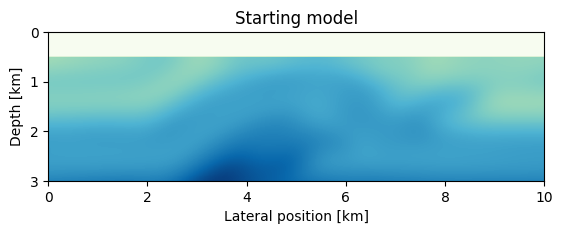

In [2]:
m0, n, d, o = read(h5open("overthrust_model.h5","r"),"m0","n","d","o"); title("Starting model")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0);
imshow(sqrt.(1f0./m0)', cmap="GnBu", extent=(0,10,3,0));
xlabel("Lateral position [km]");
ylabel("Depth [km]");

Then we read the SEG-Y file containing our test data set. The data was generated with a 2D excerpt from the Overthrust velocity model and consists of 31 shot records with 2 seconds recording time. We load the data and set up a JUDI seismic data vector:

In [3]:
block = segy_read("overthrust_shot_records.segy");
d_obs = judiVector(block);

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=7076688, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /Users/mathiaslouboutin/.julia/packages/SegyIO/uw4ZW/src/read/read_file.jl:26


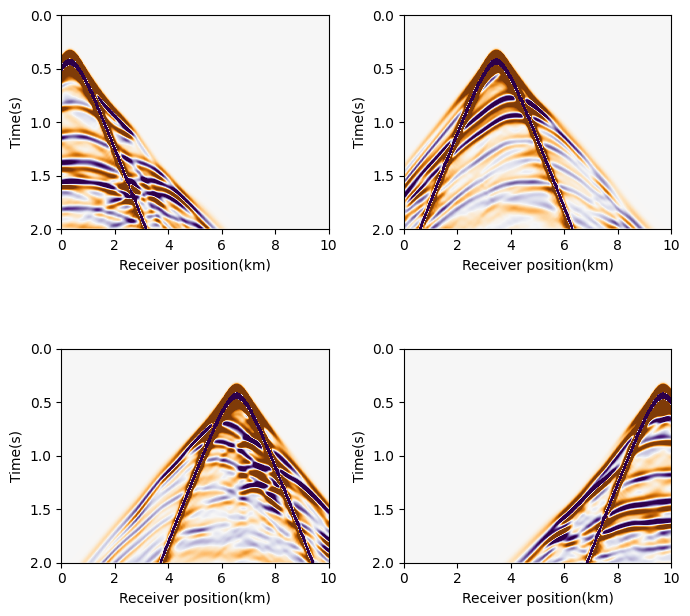

In [4]:
extent = [0, 10, 2, 0]
figure(figsize=(7, 7))
subplot(221)
imshow(d_obs.data[1], vmin=-1, vmax=1, cmap="PuOr", extent=extent, aspect=4, interpolation="hamming")
xlabel("Receiver position(km)")
ylabel("Time(s)")
subplot(222)
imshow(d_obs.data[6], vmin=-1, vmax=1, cmap="PuOr", extent=extent, aspect=4, interpolation="hamming")
xlabel("Receiver position(km)")
ylabel("Time(s)")
subplot(223)
imshow(d_obs.data[11], vmin=-1, vmax=1, cmap="PuOr", extent=extent, aspect=4, interpolation="hamming")
xlabel("Receiver position(km)")
ylabel("Time(s)")
subplot(224)
imshow(d_obs.data[16], vmin=-1, vmax=1, cmap="PuOr", extent=extent, aspect=4, interpolation="hamming")
xlabel("Receiver position(km)")
ylabel("Time(s)")
tight_layout()


Since the SEG-Y file contains the source coordinates, but not the wavelet itself, we create a JUDI `Geometry` structure for the source and then manually set up an 8 Hz Ricker wavelet. As for the observed data, we set up a JUDI seismic data vector `q` with the source geometry and wavelet:

In [5]:
src_geometry = Geometry(block; key="source");
src_data = ricker_wavelet(src_geometry.t[1], src_geometry.dt[1], 0.008f0);
q = judiVector(src_geometry, src_data);

## Optimization

Rather than implementing the L-BFGS algorithms in Julia ourselves, we interface the NLopt optimization library. This library requires objective functions with the current variable and gradient as input arguments and the function value as the only output argument. For this reason, we build a wrapper that is customized for the NLopt library around our `fwi_objective` function. The function `f!` takes a vectorized estimate of the current model as well as the (vectorized) gradient as input arguments. NLopt uses double precision for floating point variables, so the first step inside `f!` is to reshape and convert the model to single precision. Then we choose a randomized subset of sources and shot records and compute the function value `fval` and `gradient` of the FWI objective function. We then set the gradient in the water layer to zero and overwrite the input gradient `grad` with the new gradient. Furthermore, we keep track of the number of function evaluations through increasing the `count` variable, which will serve as the termination criterion for the algorithm. In Julia, we set up `f!` in the following way: 

In [18]:
batchsize = 8;
count = 0;

# NLopt objective function
function f!(x, grad)
    global count
    if count == 0
        @printf("%10s %15s %15s\n","Iteration","Function Val","norm(g)")
    end
    # Update model
    model0.m = Float32.(reshape(x,model0.n))

    # Seclect batch and calculate gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])

    # Reset gradient in water column to zero
    gradient = reshape(gradient, model0.n)
    gradient[:,1:21] .= 0f0
    grad[1:end] = vec(gradient)
          
    global count; count += 1
    @printf("%10d %15.5e %15.5e\n",count, fval, norm(g))
    return convert(Float64, fval)
end

LoadError: UndefVarError: @printf not defined

In [7]:
g = zeros(prod(model0.n))
f0 = f!(vec(model0.m), g)
# Reset count
global count = 0;

1    255339.66398837214    262117.01773563828


255339.66398837214

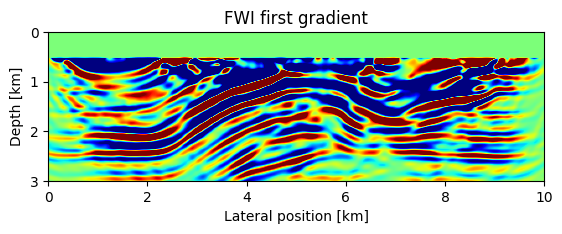

In [17]:
imshow(reshape(g, model0.n)', vmin=-1e3, vmax=1e3, extent=(0,10,3,0), cmap="jet")
title("FWI first gradient")
xlabel("Lateral position [km]");
ylabel("Depth [km]");

As in our gradient descent and Gauss-Newton example, we define bound constraints for the squared slowness to prevent velocities from becoming negative or too large:

In [9]:
# Set up bound constrains
v0 = sqrt.(1f0./model0.m)
vmin = ones(Float32, model0.n) .* 1.3f0;
vmax = ones(Float32, model0.n) .* 6.5f0;

# Convert to squared slowness
mmin = vec((1f0 ./ vmax).^2);
mmax = vec((1f0 ./ vmin).^2);

The NLopt library offers a range of different optimization algorithms, from which we choose the L-BFGS method. We create an optimization object called `opt` by specifying the algorithm we want to use and the dimenions of the unknown model vector. We then set the upper and lower bounds of the variable, define `f!` as the objective function and set the termination criterion to be a maximum of 15 function evaluations:

In [10]:
opt = Opt(:LD_LBFGS, prod(model0.n))
lower_bounds!(opt, mmin)
upper_bounds!(opt, mmax)
min_objective!(opt, f!)
maxeval!(opt, 15)

Remark: Subsampling the number of sources should in practice never be used for second order methods such as L-BFGS. Specialized stochastic second order methods exist, but differ from standard Quasi-Newton methods. We only use source subsampling to reduce the computational cost of our example. Having set up the objective function, bound constraints and termination criterion, we can now run the inversion:

** This example requires ~200 MB of memory per gradient, i.e. 800 MB with four parallel workers. It runs for approximately 15 minutes. **

In [11]:
(minf, minx, ret) = optimize(opt, vec(model0.m));

2    257901.94477162338    258980.10388516955
3    172803.59079827153    302780.85054677405
4    189130.6172962864    318396.30082959705
5    206791.76877585545    375180.5596427598
6    214141.76860964662    406769.76629408816
7    364202.2299721926    359639.79808253766
8    144399.94956911763    208320.48800925835
9    115243.88926892391    196391.16164069102
10    83024.91172473418    233775.52396071967
11    79410.95713778166    217893.00687219884
12    67300.58613575318    210013.1922979365
13    51630.938175045296    108049.05286704176
14    46403.458416860216    117827.36750250543
15    43086.70610388414    94403.35456695667
16    35267.624712575205    96966.99249506553


We plot the final velocity model after 15 function evaluations:

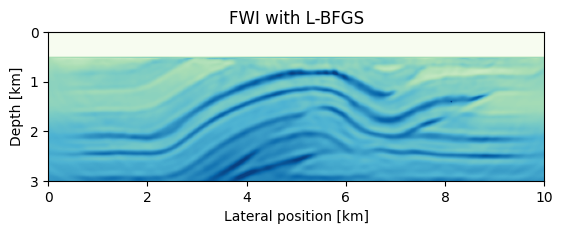

In [15]:
imshow(sqrt.(1f0./reshape(minx, model0.n))', cmap="GnBu", extent=(0,10,3,0), vmin=1.5, vmax=5.4); title("FWI with L-BFGS")
xlabel("Lateral position [km]");
ylabel("Depth [km]");